In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Definition of the function with exponential and sinusoidal terms
def func_trans(x):
    result = (20*x+3*x**2+0.1*x**3)*np.sin(x)*np.exp(-0.5*x)
    return (result)

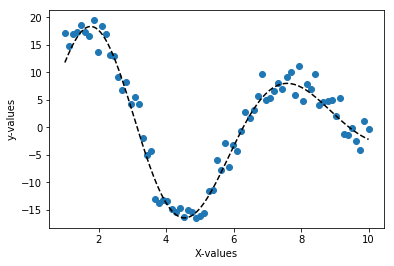

In [4]:
# Generate data
N_points = 75 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 10 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 2 # Std.Dev of the Gaussian noise adder

# Densely spaced points for generating the ideal functional curve
x_smooth = np.array(np.linspace(x_min,x_max,501))

# Use one of the following
y_smooth = func_trans(x_smooth)

# Linearly spaced sample points
X=np.array(np.linspace(x_min,x_max,N_points))

# Added observational/measurement noise
np.random.seed(101)
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)

# Observed output after adding the noise
y = func_trans(X)+noise_x

plt.figure()
plt.scatter(X, y)
plt.plot(x_smooth, y_smooth, 'k--')
plt.xlabel("X-values")
plt.ylabel("y-values")
plt.show()

In [6]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Turn into 2D array
X_train = X_train.reshape(X_train.size, 1)
y_train = y_train.reshape(y_train.size, 1)
X_test = X_test.reshape(X_test.size, 1)
y_test = y_test.reshape(y_test.size, 1)

In [7]:
# Scale data
from sklearn.preprocessing import StandardScaler

scalerx = StandardScaler()
scalery = StandardScaler()

X_train_scaled = scalerx.fit_transform(X_train)
y_train_scaled = scalery.fit_transform(y_train)
X_test_scaled = scalerx.fit_transform(X_test)
y_test_scaled = scalery.fit_transform(y_test)

In [8]:
import tensorflow as tf

In [9]:
def build_regression_model(
    input_neurons=10, input_dim=1, num_layers=1, architecture=[32], act_func="relu"
):
    """
  Builds a densely connected neural network model from user input
  
  Arguments
          num_layers: Number of hidden layers
          architecture: Architecture of the hidden layers (densely connected)
          act_func: Activation function. Could be 'relu', 'sigmoid', or 'tanh'.
          input_shape: Dimension of the input vector
  Returns
          A neural net (Keras) model for regression
  """
    if act_func == "relu":
        activation = tf.nn.relu
    elif act_func == "sigmoid":
        activation = tf.nn.sigmoid
    elif act_func == "tanh":
        activation = tf.nn.tanh

    layers = [
        tf.keras.layers.Dense(input_neurons, input_dim=input_dim, activation=activation)
    ]

    for i in range(num_layers):
        layers.append(tf.keras.layers.Dense(architecture[i], activation=activation))
    layers.append(tf.keras.layers.Dense(1))

    model = tf.keras.models.Sequential(layers)
    return model


def compile_train_regression_model(
    model,
    x_train,
    y_train,
    callbacks=None,
    learning_rate=0.001,
    batch_size=1,
    epochs=10,
    verbose=0,
):
    """
  Compiles and trains a given Keras model with the given data for regression. 
  Assumes Adam optimizer for this implementation.
  Assumes mean-squared-error loss
  
  Arguments
          learning_rate: Learning rate for the optimizer Adam
          batch_size: Batch size for the mini-batch operation
          epochs: Number of epochs to train
          verbose: Verbosity of the training process
  
  Returns
  A copy of the model
  """

    model_copy = model
    model_copy.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss="mean_squared_error",
        metrics=["accuracy"],
    )
    if callbacks != None:
        model_copy.fit(
            x_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[callbacks],
            verbose=verbose,
        )
    else:
        model_copy.fit(
            x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose
        )
    return model_copy

In [11]:
# Single layer
architecture = [32]
input_neurons = 32
num_layers = 1
activation = 'relu'
input_dim = 1

nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model
trained_model = compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=1,verbose=0,epochs=100)

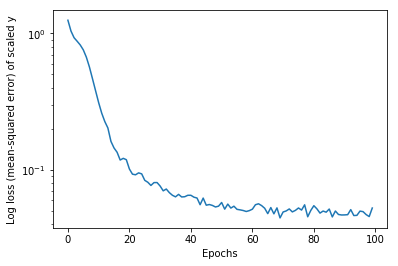

In [13]:
plt.figure()
plt.semilogy(trained_model.history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Log loss (mean-squared error) of scaled y")
plt.show()

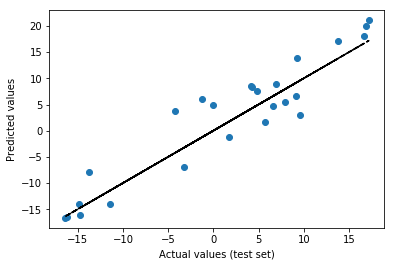

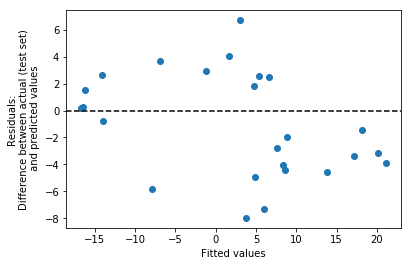

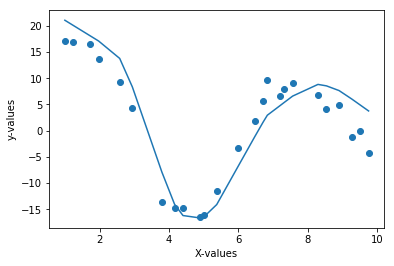

In [26]:
yhat = scalery.inverse_transform(trained_model.predict(X_test_scaled))

plt.figure()
plt.xlabel("Actual values (test set)")
plt.ylabel("Predicted values")
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, 'k--')
plt.show()

plt.figure()
plt.scatter(yhat, y_test - yhat)
plt.xlabel("Fitted values")
plt.ylabel("Residuals:\nDifference between actual (test set)\n and predicted values")
plt.axhline(y=0, ls='--', c='k')
plt.show()

plt.figure()
plt.scatter(X_test, y_test, label='actual values (test set)')
argsort = np.argsort(X_test, axis=0)
plt.plot(X_test[argsort][:, 0, 0], yhat[argsort][:, 0, 0], label='predicted values')
plt.xlabel("X-values")
plt.ylabel("y-values")
plt.show()

In [38]:
# Play with a different data set
from sklearn.datasets import make_friedman2
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Turn into 2D array
y_train = y_train.reshape(y_train.size, 1)
y_test = y_test.reshape(y_test.size, 1)

# Scale data
scalerx = StandardScaler()
scalery = StandardScaler()

X_train_scaled = scalerx.fit_transform(X_train)
y_train_scaled = scalery.fit_transform(y_train)
X_test_scaled = scalerx.fit_transform(X_test)
y_test_scaled = scalery.fit_transform(y_test)

In [42]:
# Single layer
architecture = [32]
input_neurons = 32
num_layers = 1
activation = 'relu'
input_dim = 4

nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)
nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


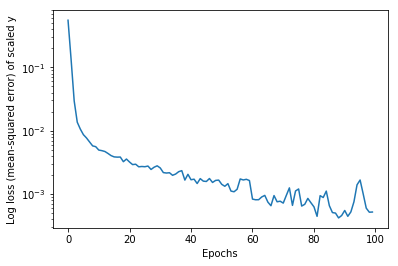

In [43]:
# Train with more bigger batch size
trained_model = compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=4,verbose=0,epochs=100)

plt.figure()
plt.semilogy(trained_model.history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Log loss (mean-squared error) of scaled y")
plt.show()

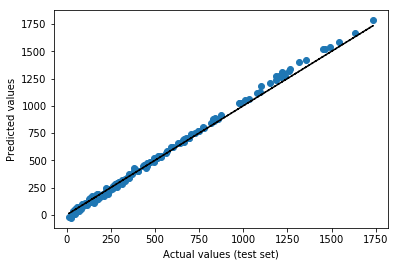

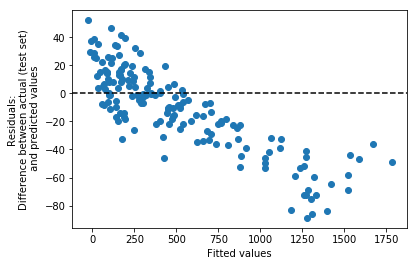

In [44]:
yhat = scalery.inverse_transform(trained_model.predict(X_test_scaled))

plt.figure()
plt.xlabel("Actual values (test set)")
plt.ylabel("Predicted values")
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, 'k--')
plt.show()

plt.figure()
plt.scatter(yhat, y_test - yhat)
plt.xlabel("Fitted values")
plt.ylabel("Residuals:\nDifference between actual (test set)\n and predicted values")
plt.axhline(y=0, ls='--', c='k')
plt.show()

In [45]:
# Try two hidden layers and more epochs
architecture = [32,32]
input_neurons = 32
num_layers = 2
activation = 'relu'
input_dim = 4

nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)
nn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


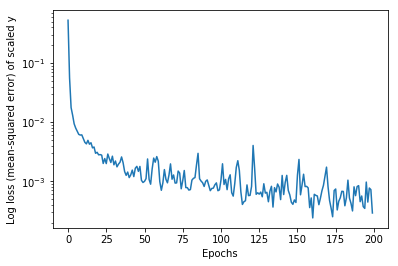

In [46]:
# Train with more bigger batch size
trained_model = compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=4,verbose=0,epochs=200)

plt.figure()
plt.semilogy(trained_model.history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Log loss (mean-squared error) of scaled y")
plt.show()

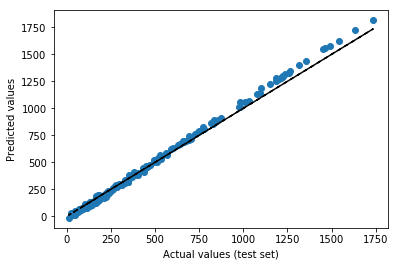

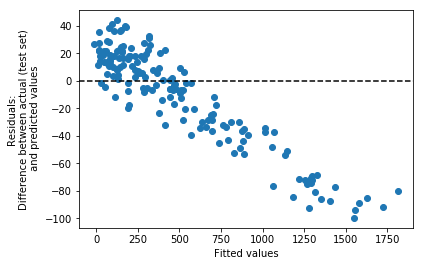

In [47]:
yhat = scalery.inverse_transform(trained_model.predict(X_test_scaled))

plt.figure()
plt.xlabel("Actual values (test set)")
plt.ylabel("Predicted values")
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, 'k--')
plt.show()

plt.figure()
plt.scatter(yhat, y_test - yhat)
plt.xlabel("Fitted values")
plt.ylabel("Residuals:\nDifference between actual (test set)\n and predicted values")
plt.axhline(y=0, ls='--', c='k')
plt.show()